# $$\large\text{Water Potability Prediction}$$
## $$\text{Kevin Milli}$$

`ph`: This variable represents the pH value in water. pH measures the acidity or alkalinity of water on a scale from *0* to *14*, where *7* is `neutral`, values below indicate acidity, and values above indicate alkalinity.

`Hardness`: Indicates the hardness of water, measured in units of dissolved calcium and magnesium concentration in water. High hardness can affect the quality of drinking water.

`Solids`: This variable represents the concentration of total dissolved solids in water. It includes all inorganic and organic solids present in the water.

`Chloramines`: Indicates the concentration of chloramines in water, a chemical compound used as a disinfectant to make water safe to drink.

`Sulfate`: This variable represents the concentration of sulfates in water. Sulfates can affect the taste of water and may have implications for human health.

`Conductivity`: Measures the water's ability to conduct electricity. It is influenced by the presence of ions in the water and can be used as an indicator of water quality.

`Organic_carbon`: This variable represents the concentration of organic carbon in water. Organic carbon comes from dissolved organic substances in the water.

`Trihalomethanes`: Indicates the concentration of trihalomethanes in water, which are byproducts of chlorination. **They may have implications for human health**.

`Turbidity`: Represents the turbidity of water, i.e., clarity or cloudiness. High values indicate cloudy water, while low values indicate clear water.

`Potability`: This binary variable (0 or 1) indicates whether the water is potable (1) or not potable (0), based on established water quality criteria.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier 
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC

# Data Preprocessing and Model Selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set() # darkgrid

In [3]:
df = pd.read_csv('water_potability.csv')

In [4]:
def plot_distributions(df, row_size=12, col_size=12):
    """
    By passing a DataFrame, it plots all the distributions, indicating
    the Mean plus the first and second standard deviations. 
    All values in the passed DataFrame must be numerical.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        row_size (int): The height of the plot.
        col_size (int): The width of the plot.
    """

    if len(df.columns)%2 == 0:
        col_len = int(len(df.columns)/4)
        row_len = 4
    else:
        col_len = int(len(df.columns)/3)
        row_len = 3
    
    fig,axes = plt.subplots(row_len, 2, figsize=(row_size, col_size), dpi=180)
    
    for i, ax in enumerate(axes.ravel()):
        if i < len(df.columns) - 1:
            col_name = df.columns[i]
            sns.histplot(data=df, x=col_name, ax=ax, kde=True, color='skyblue')
            ax.axvline(df[col_name].mean(), color='red', linestyle='dashed', linewidth=2, label='$\mu$')
            ax.axvline(df[col_name].mean() + df[col_name].std(), color='green', linestyle='dashed', linewidth=2, label='$\mu+\sigma$')
            ax.axvline(df[col_name].mean() - df[col_name].std(), color='blue', linestyle='dashed', linewidth=2, label='$\mu-\sigma$')
            ax.axvline(df[col_name].mean() + df[col_name].std() * 2, color='orange', linestyle=':', linewidth=3, label='$\mu+2\sigma$')
            ax.axvline(df[col_name].mean() - df[col_name].std() * 2, color='purple', linestyle=':', linewidth=3, label='$\mu-2\sigma$')
            ax.legend()
            ax.set_title(f'{col_name} Distribution')
    
    plt.tight_layout()
    plt.show()
    

In [5]:
def plot_comparison_distributions(df1, df2, row_size=12, col_size=12):
    """
    Plots the distributions of two dataframes with the same column names side by side.

    Parameters:
        df1 (pd.DataFrame): The first dataframe.
        df2 (pd.DataFrame): The second dataframe.
        row_size (int): The height of the plot.
        col_size (int): The width of the plot.
    """ 
    if len(df1.columns) != len(df2.columns):
        raise ValueError("Both dataframes must have the same number of columns")

    num_columns = len(df1.columns)

    fig, axes = plt.subplots(num_columns, 2, figsize=(row_size, col_size), dpi=180)

    for i, (col_name1, col_name2) in enumerate(zip(df1.columns, df2.columns)):
        sns.histplot(data=df1, x=col_name1, ax=axes[i][0], kde=True, color='skyblue')
        sns.histplot(data=df2, x=col_name2, ax=axes[i][1], kde=True, color='orange')
        
        axes[i][0].axvline(df1[col_name1].mean(), color='red', linestyle='dashed', linewidth=2, label='$\mu$')
        axes[i][1].axvline(df2[col_name2].mean(), color='red', linestyle='dashed', linewidth=2, label='$\mu$')
        
        axes[i][0].axvline(df1[col_name1].mean() + df1[col_name1].std(), color='green', linestyle='dashed', linewidth=2, label='$\mu+\sigma$')
        axes[i][1].axvline(df2[col_name2].mean() + df2[col_name2].std(), color='green', linestyle='dashed', linewidth=2, label='$\mu+\sigma$')
        
        axes[i][0].axvline(df1[col_name1].mean() - df1[col_name1].std(), color='blue', linestyle='dashed', linewidth=2, label='$\mu-\sigma$')
        axes[i][1].axvline(df2[col_name2].mean() - df2[col_name2].std(), color='blue', linestyle='dashed', linewidth=2, label='$\mu-\sigma$')
        
        axes[i][0].axvline(df1[col_name1].mean() + df1[col_name1].std() * 2, color='brown', linestyle=':', linewidth=3, label='$\mu+2\sigma$')
        axes[i][1].axvline(df2[col_name2].mean() + df2[col_name2].std() * 2, color='purple', linestyle=':', linewidth=3, label='$\mu+2\sigma$')
        
        axes[i][0].axvline(df1[col_name1].mean() - df1[col_name1].std() * 2, color='purple', linestyle=':', linewidth=3, label='$\mu-2\sigma$')
        axes[i][1].axvline(df2[col_name2].mean() - df2[col_name2].std() * 2, color='brown', linestyle=':', linewidth=3, label='$\mu-2\sigma$')
        
        axes[i][0].legend()
        axes[i][1].legend()
        axes[i][0].set_title(f'{col_name1} Distribution')
        axes[i][1].set_title(f'{col_name2} Distribution')

    plt.tight_layout()
    plt.savefig('dist_df_vs_df.png')
    plt.show()    

In [6]:
def split_data(X, y, test_size=0.3, val_size=0.5, random_state=42):
    """
    The split_data function is designed to simplify
    the process of splitting a dataset into three parts:
    training set, validation set, and test set.
    
    Parameters:
    
        X: The DataFrame of features, the dataset to be split.
        y: The Series or array of labels corresponding to the features in the dataset.
        test_size (default=0.4): The proportion of the dataset to allocate as the test set.
        val_size (default=0.5): The proportion of the test set to allocate as the validation set.
        random_state (default=42): The seed for data splitting reproducibility.
    
    Output: X_train, X_val, X_test, y_train, y_val, y_test
    """

    splitter = StratifiedShuffleSplit(random_state=random_state, test_size=test_size, n_splits=1)
    
    for train_idx, test_idx in splitter.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    splitter2 = StratifiedShuffleSplit(random_state=random_state, test_size=val_size, n_splits=1)
    
    for train_idx, val_idx in splitter2.split(X_test, y_test):
        X_test, X_val = X_test.iloc[train_idx], X_test.iloc[val_idx]
        y_test, y_val = y_test.iloc[train_idx], y_test.iloc[val_idx]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

## EDA

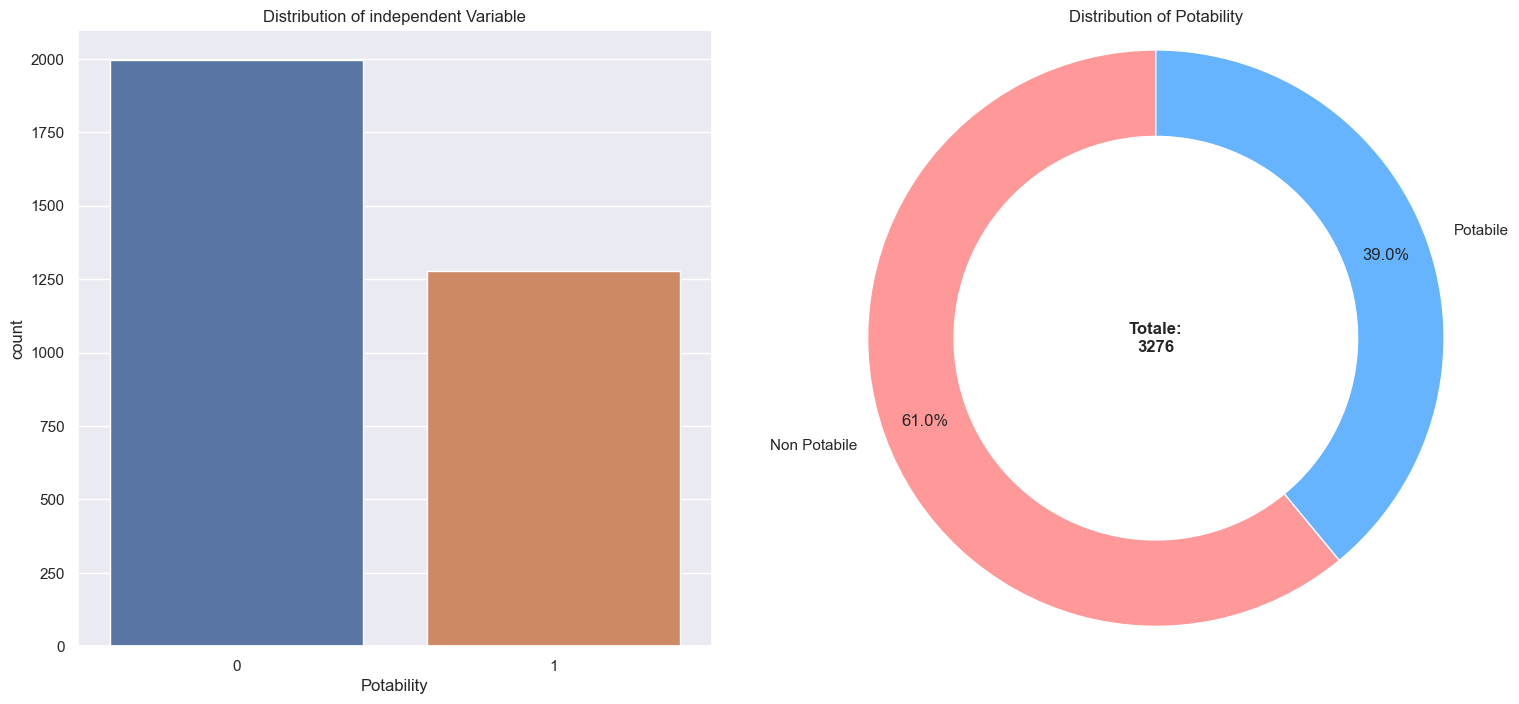

In [14]:
count = df['Potability'].value_counts()
labels = ['Not Potable', 'Potable']
colors = ['#ff9999', '#66b3ff']

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Count Plot
sns.countplot(data=df, x='Potability', ax=ax[0])
ax[0].set_title('Distribution of the Independent Variable')

# Pie Chart
ax[1].pie(count, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Create a white circle in the center to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Total occurrences
total = sum(count)

# Display the total in the center of the pie
ax[1].text(0, 0, f'Total:\n{total}', ha='center', va='center', fontsize=12, fontweight='bold')

ax[1].set_title('Distribution of Potability')
ax[1].axis('equal')  # To maintain the circular aspect ratio

plt.show()

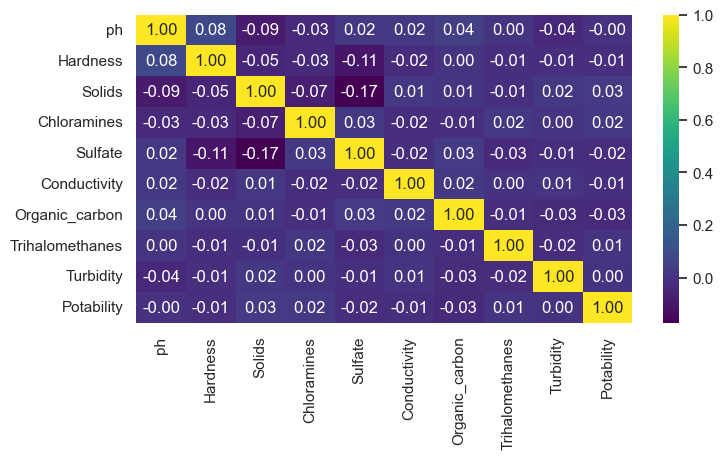

In [8]:
plt.figure(figsize=(8,4))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='viridis');

## Missing Values

In [9]:
null = df.isnull().sum()
null[null>0]

ph                 491
Sulfate            781
Trihalomethanes    162
dtype: int64

In [10]:
print(df.shape)
df = df.dropna()
df.shape

(3276, 10)


(2011, 10)

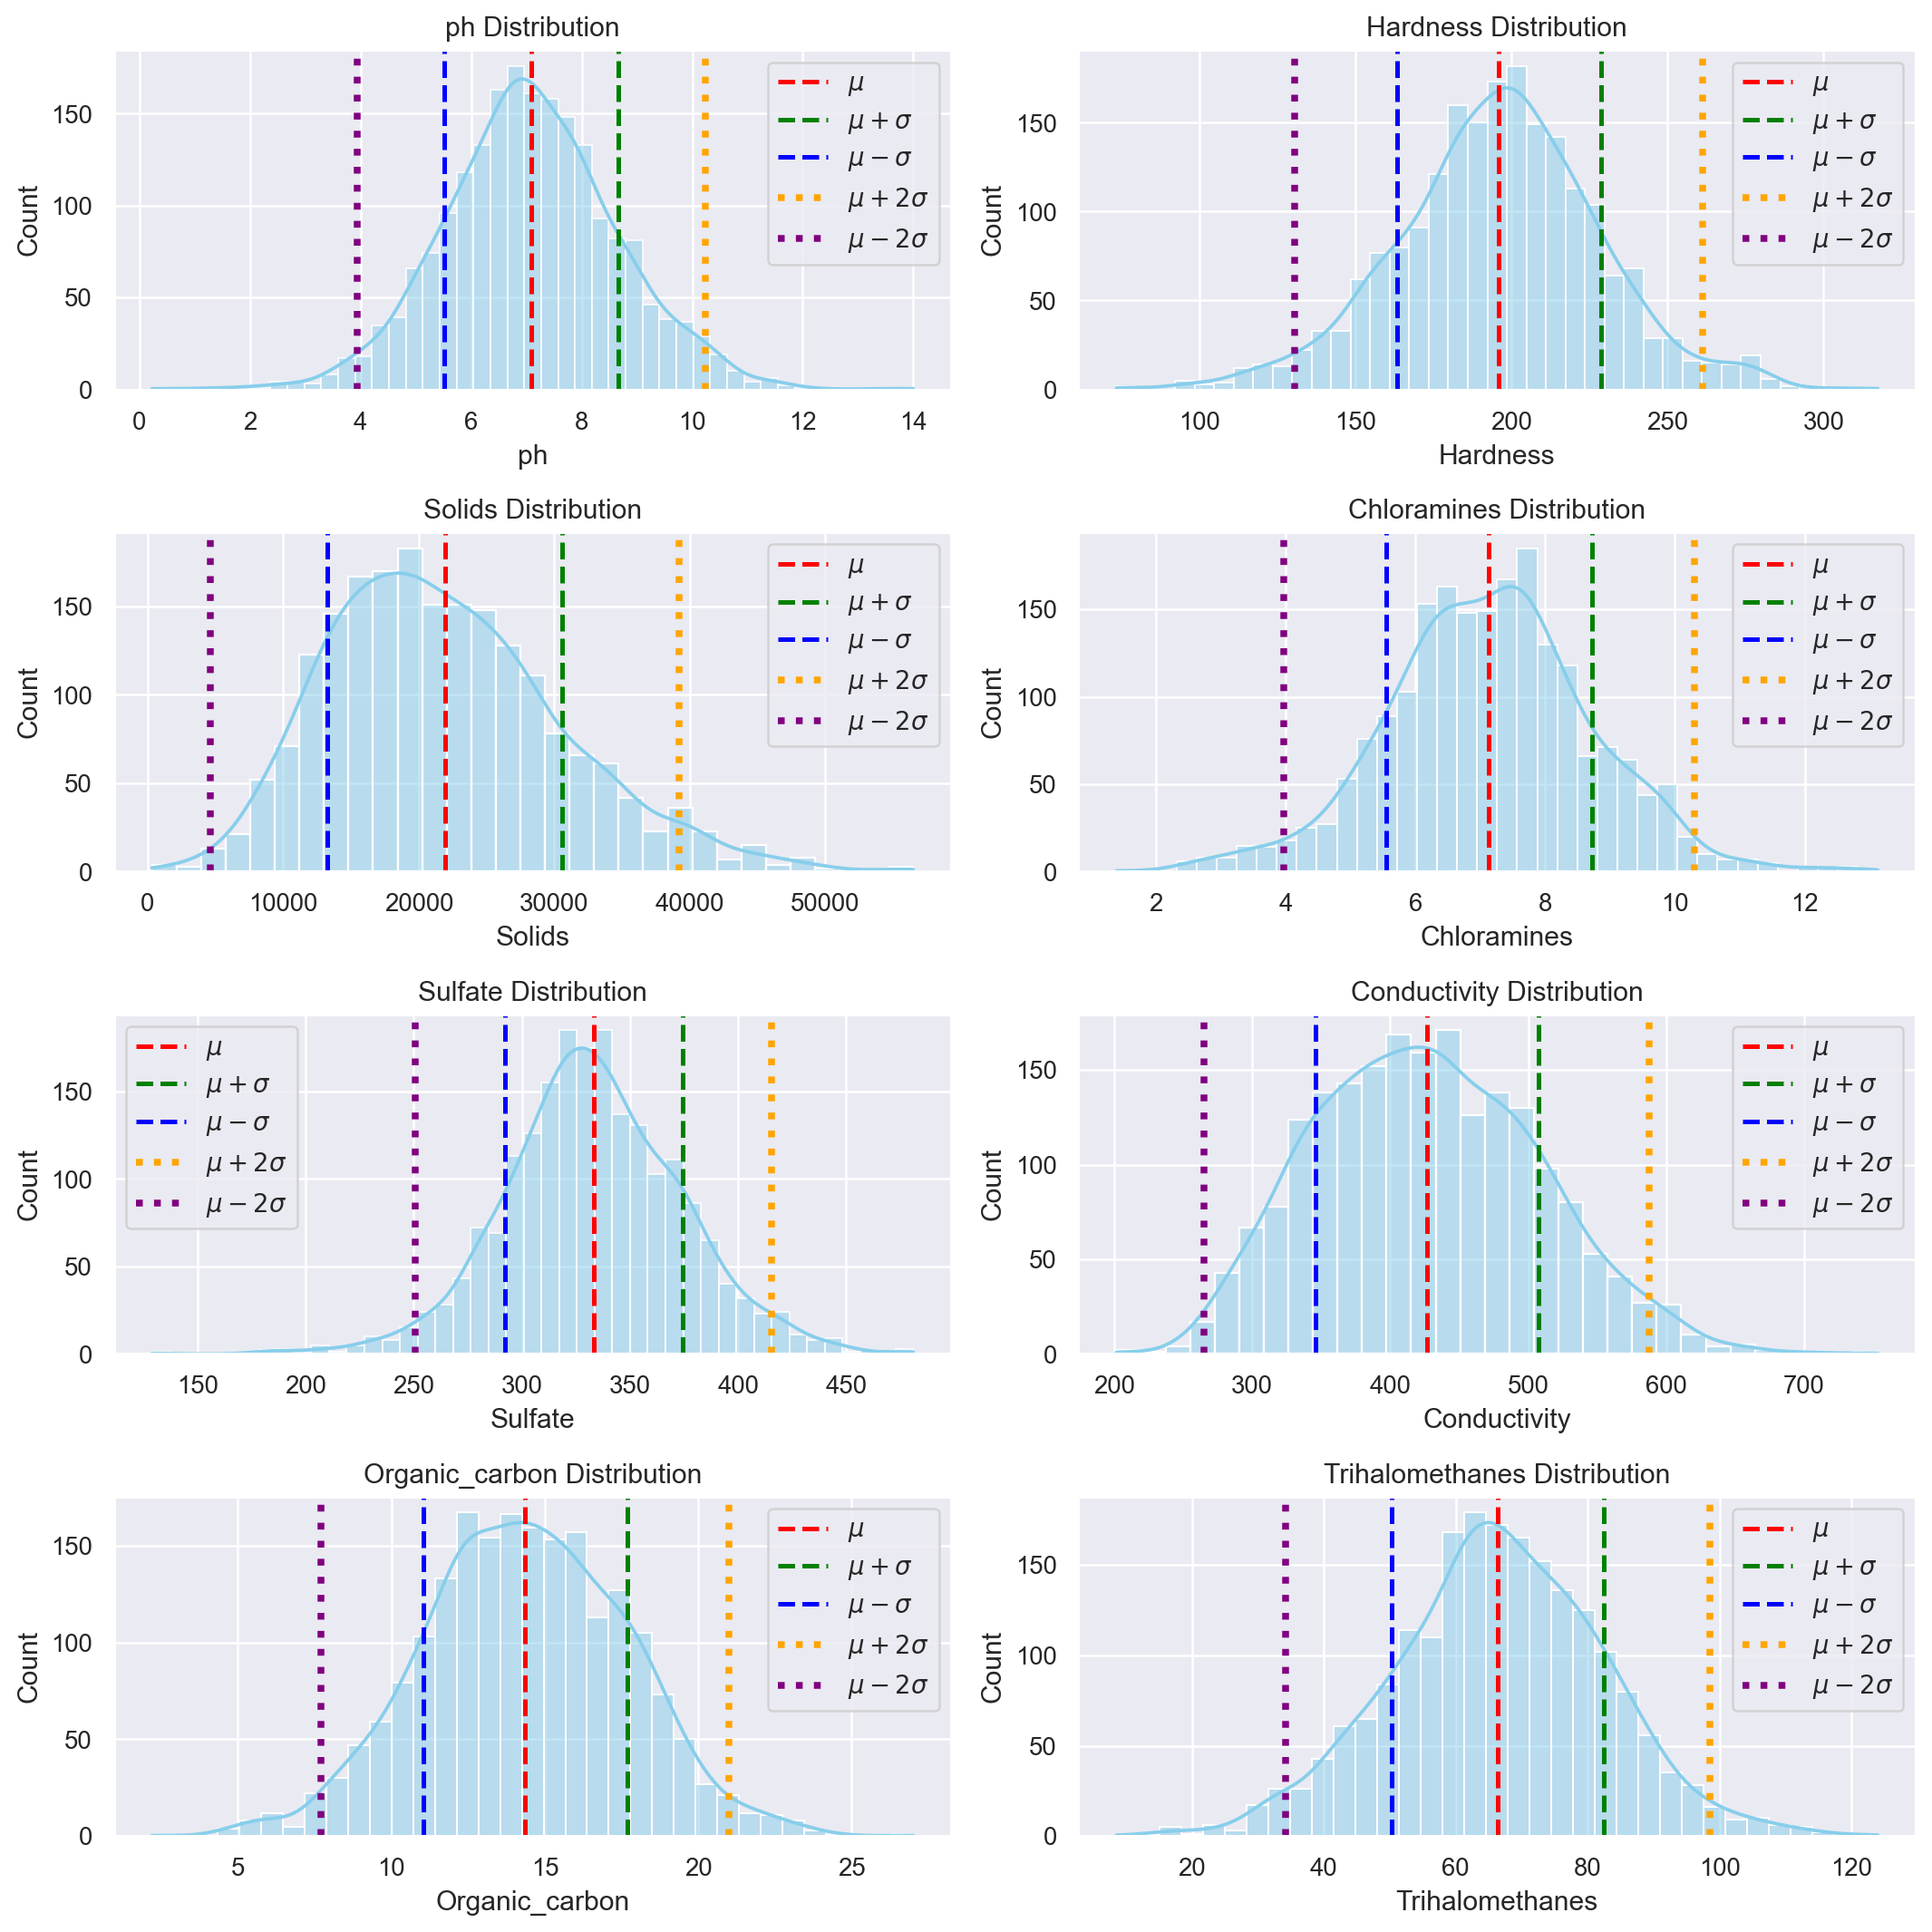

In [12]:
plot_distributions(df)

In [13]:
df.groupby('Potability').describe().T

Potability                        0             1
ph              count   1200.000000    811.000000
                mean       7.067201      7.113791
                std        1.659106      1.437623
                min        1.431782      0.227499
                25%        5.982888      6.256039
                50%        6.992004      7.046549
                75%        8.141979      7.955161
                max       14.000000     11.898078
Hardness        count   1200.000000    811.000000
                mean     196.008440    195.908341
                std       30.717642     35.301146
                min       98.452931     73.492234
                25%      177.313440    174.380497
                50%      196.799368    197.617494
                75%      214.532109    218.414531
                max      300.292476    317.338124
Solids          count   1200.000000    811.000000
                mean   21628.535122  22344.922883
                std     8461.108693   8891.547966
                min      320.942611   1198.943699
                25%    15378.907323  15816.076607
                50%    20507.399647  21217.158596
                75%    26786.546213  27696.134419
                max    55334.702799  56488.672413
Chloramines     count   1200.000000    811.000000
                mean       7.107267      7.174395
                std        1.476577      1.732796
                min        2.456014      1.390871
                25%        6.169384      6.106169
                50%        7.103718      7.212254
                75%        8.076759      8.181431
                max       12.653362     13.127000
Sulfate         count   1200.000000    811.000000
                mean     333.742928    332.457832
                std       36.398403     47.446190
                min      203.444521    129.000000
                25%      310.653441    301.768819
                50%      332.615625    331.087177
                75%      356.432048    365.632984
                max      460.107069    481.030642
Conductivity    count   1200.000000    811.000000
                mean     427.554342    425.005423
                std       79.882677     81.950982
                min      210.319182    201.619737
                25%      369.580980    360.275012
                50%      424.479471    421.099917
                75%      482.333786    482.296528
                max      753.342620    695.369528
Organic_carbon  count   1200.000000    811.000000
                mean      14.400250     14.294764
                std        3.370196      3.257917
                min        4.371899      2.200000
                25%       12.118659     12.148355
                50%       14.351828     14.252684
                75%       16.787531     16.561121
                max       27.006707     23.604298
Trihalomethanes count   1200.000000    811.000000
                mean      66.278712     66.581596
                std       15.931953     16.297713
                min       14.343161      8.577013
                25%       56.152070     55.751069
                50%       66.206116     66.612984
                75%       77.144621     77.372587
                max      120.030077    124.000000
Turbidity       count   1200.000000    811.000000
                mean       3.955181      3.991254
                std        0.782984      0.776408
                min        1.450000      1.492207
                25%        3.444706      3.440564
                50%        3.944085      4.007347
                75%        4.497522      4.527463
                max        6.494749      6.494249

In [14]:
df.head(2)

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0

I create **two dataframes** representing data with `potable water` and data with `non-potable` water. 

This allows me to compare the two distributions:

In [15]:
df_not_potable = df[df['Potability']==0]
df_potable = df[df['Potability']==1]

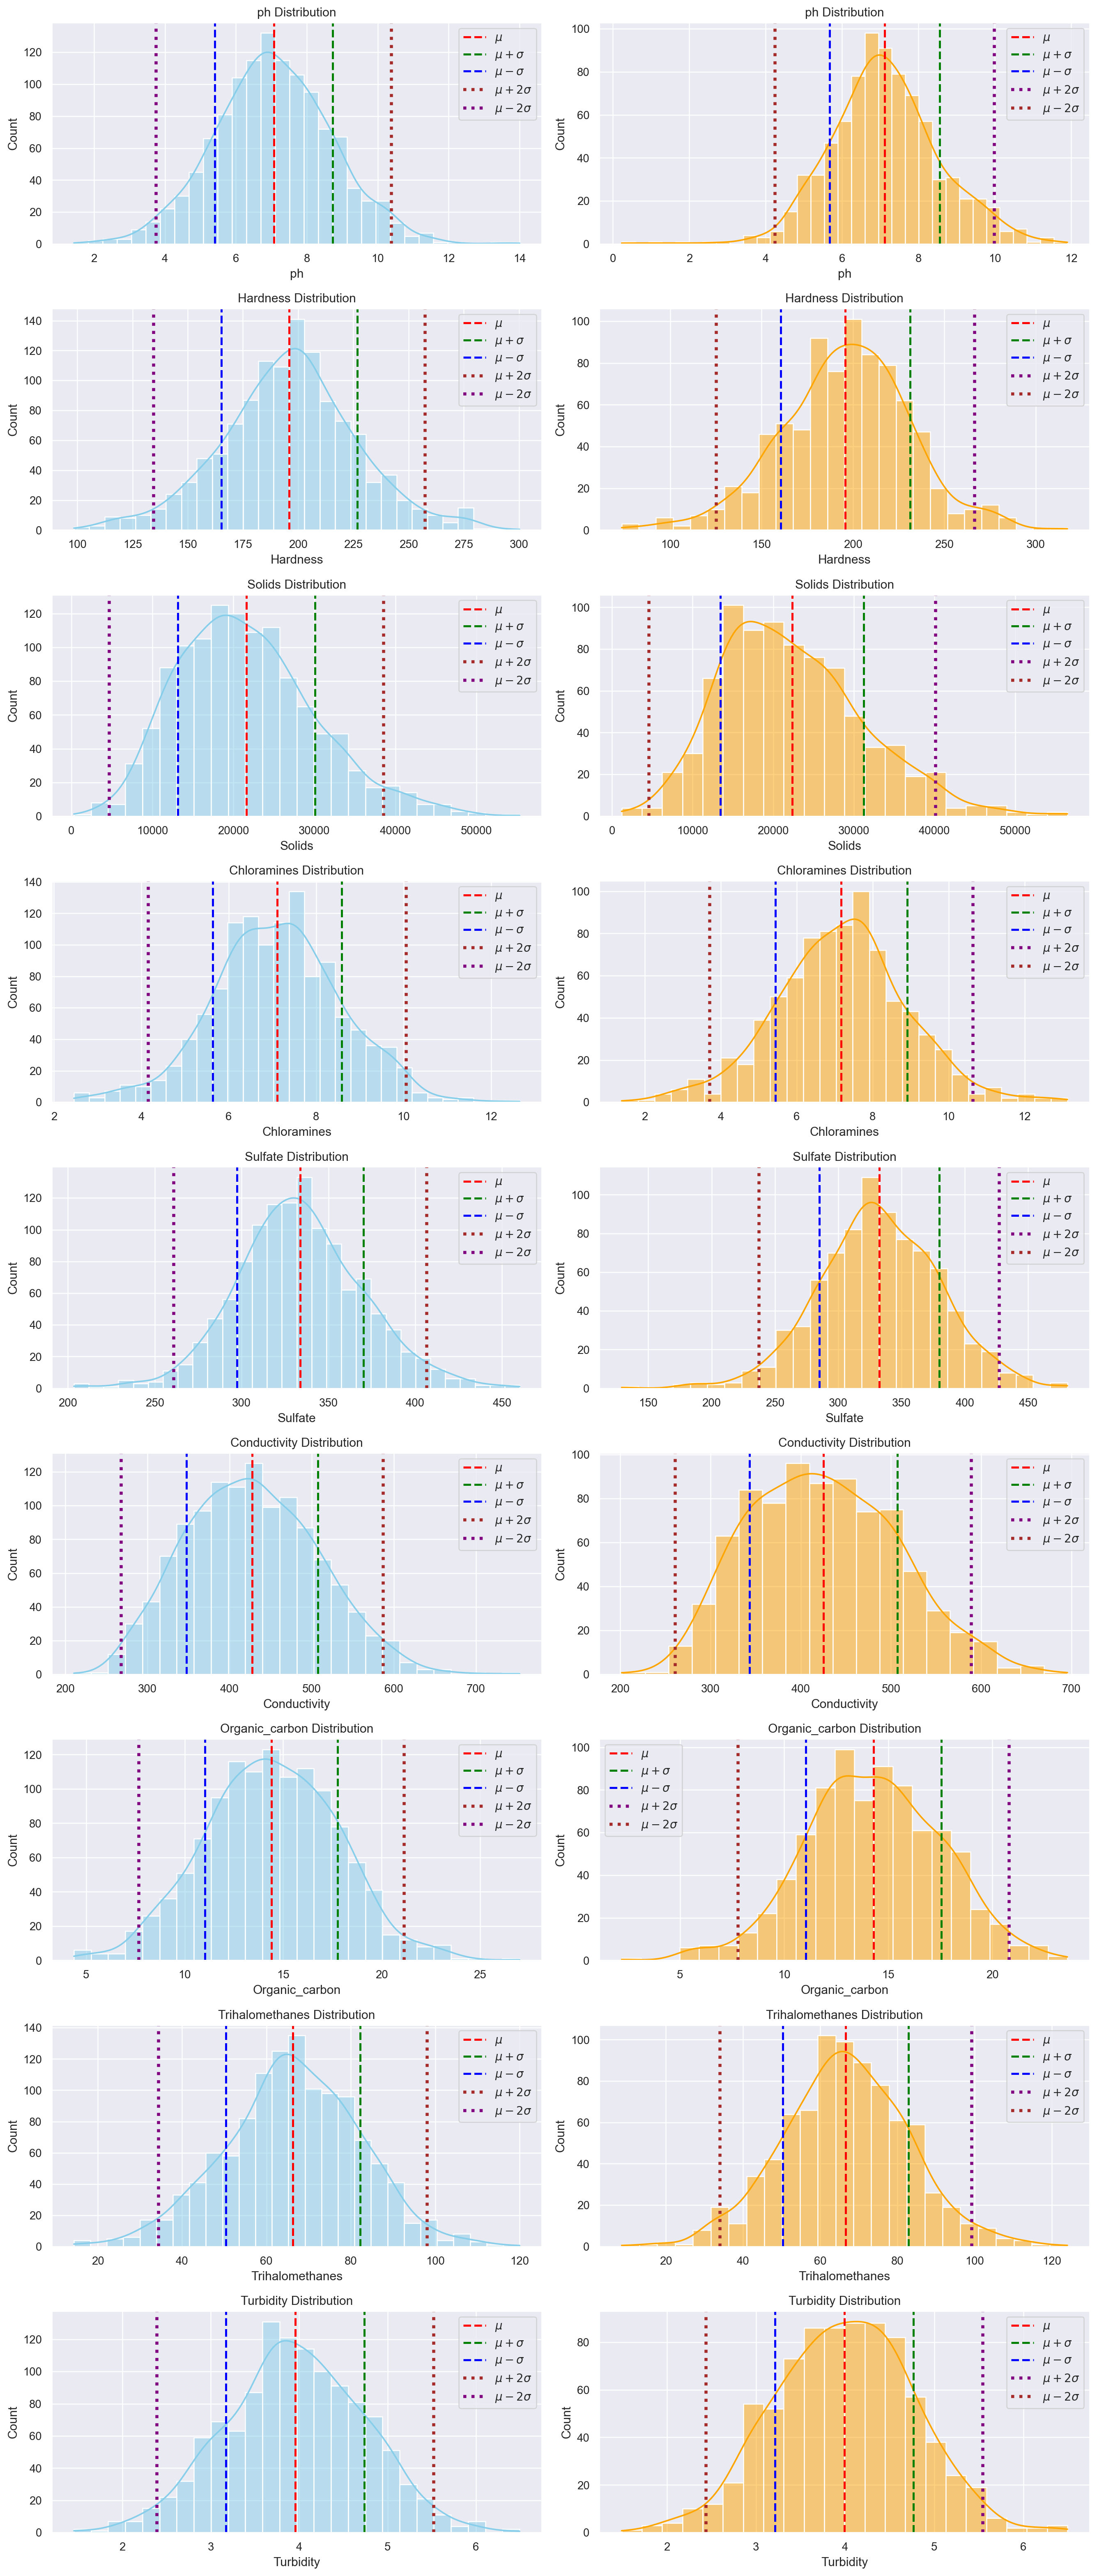

In [16]:
plot_comparison_distributions(df_not_potable.drop('Potability',axis=1), df_potable.drop('Potability',axis=1), 15,35)

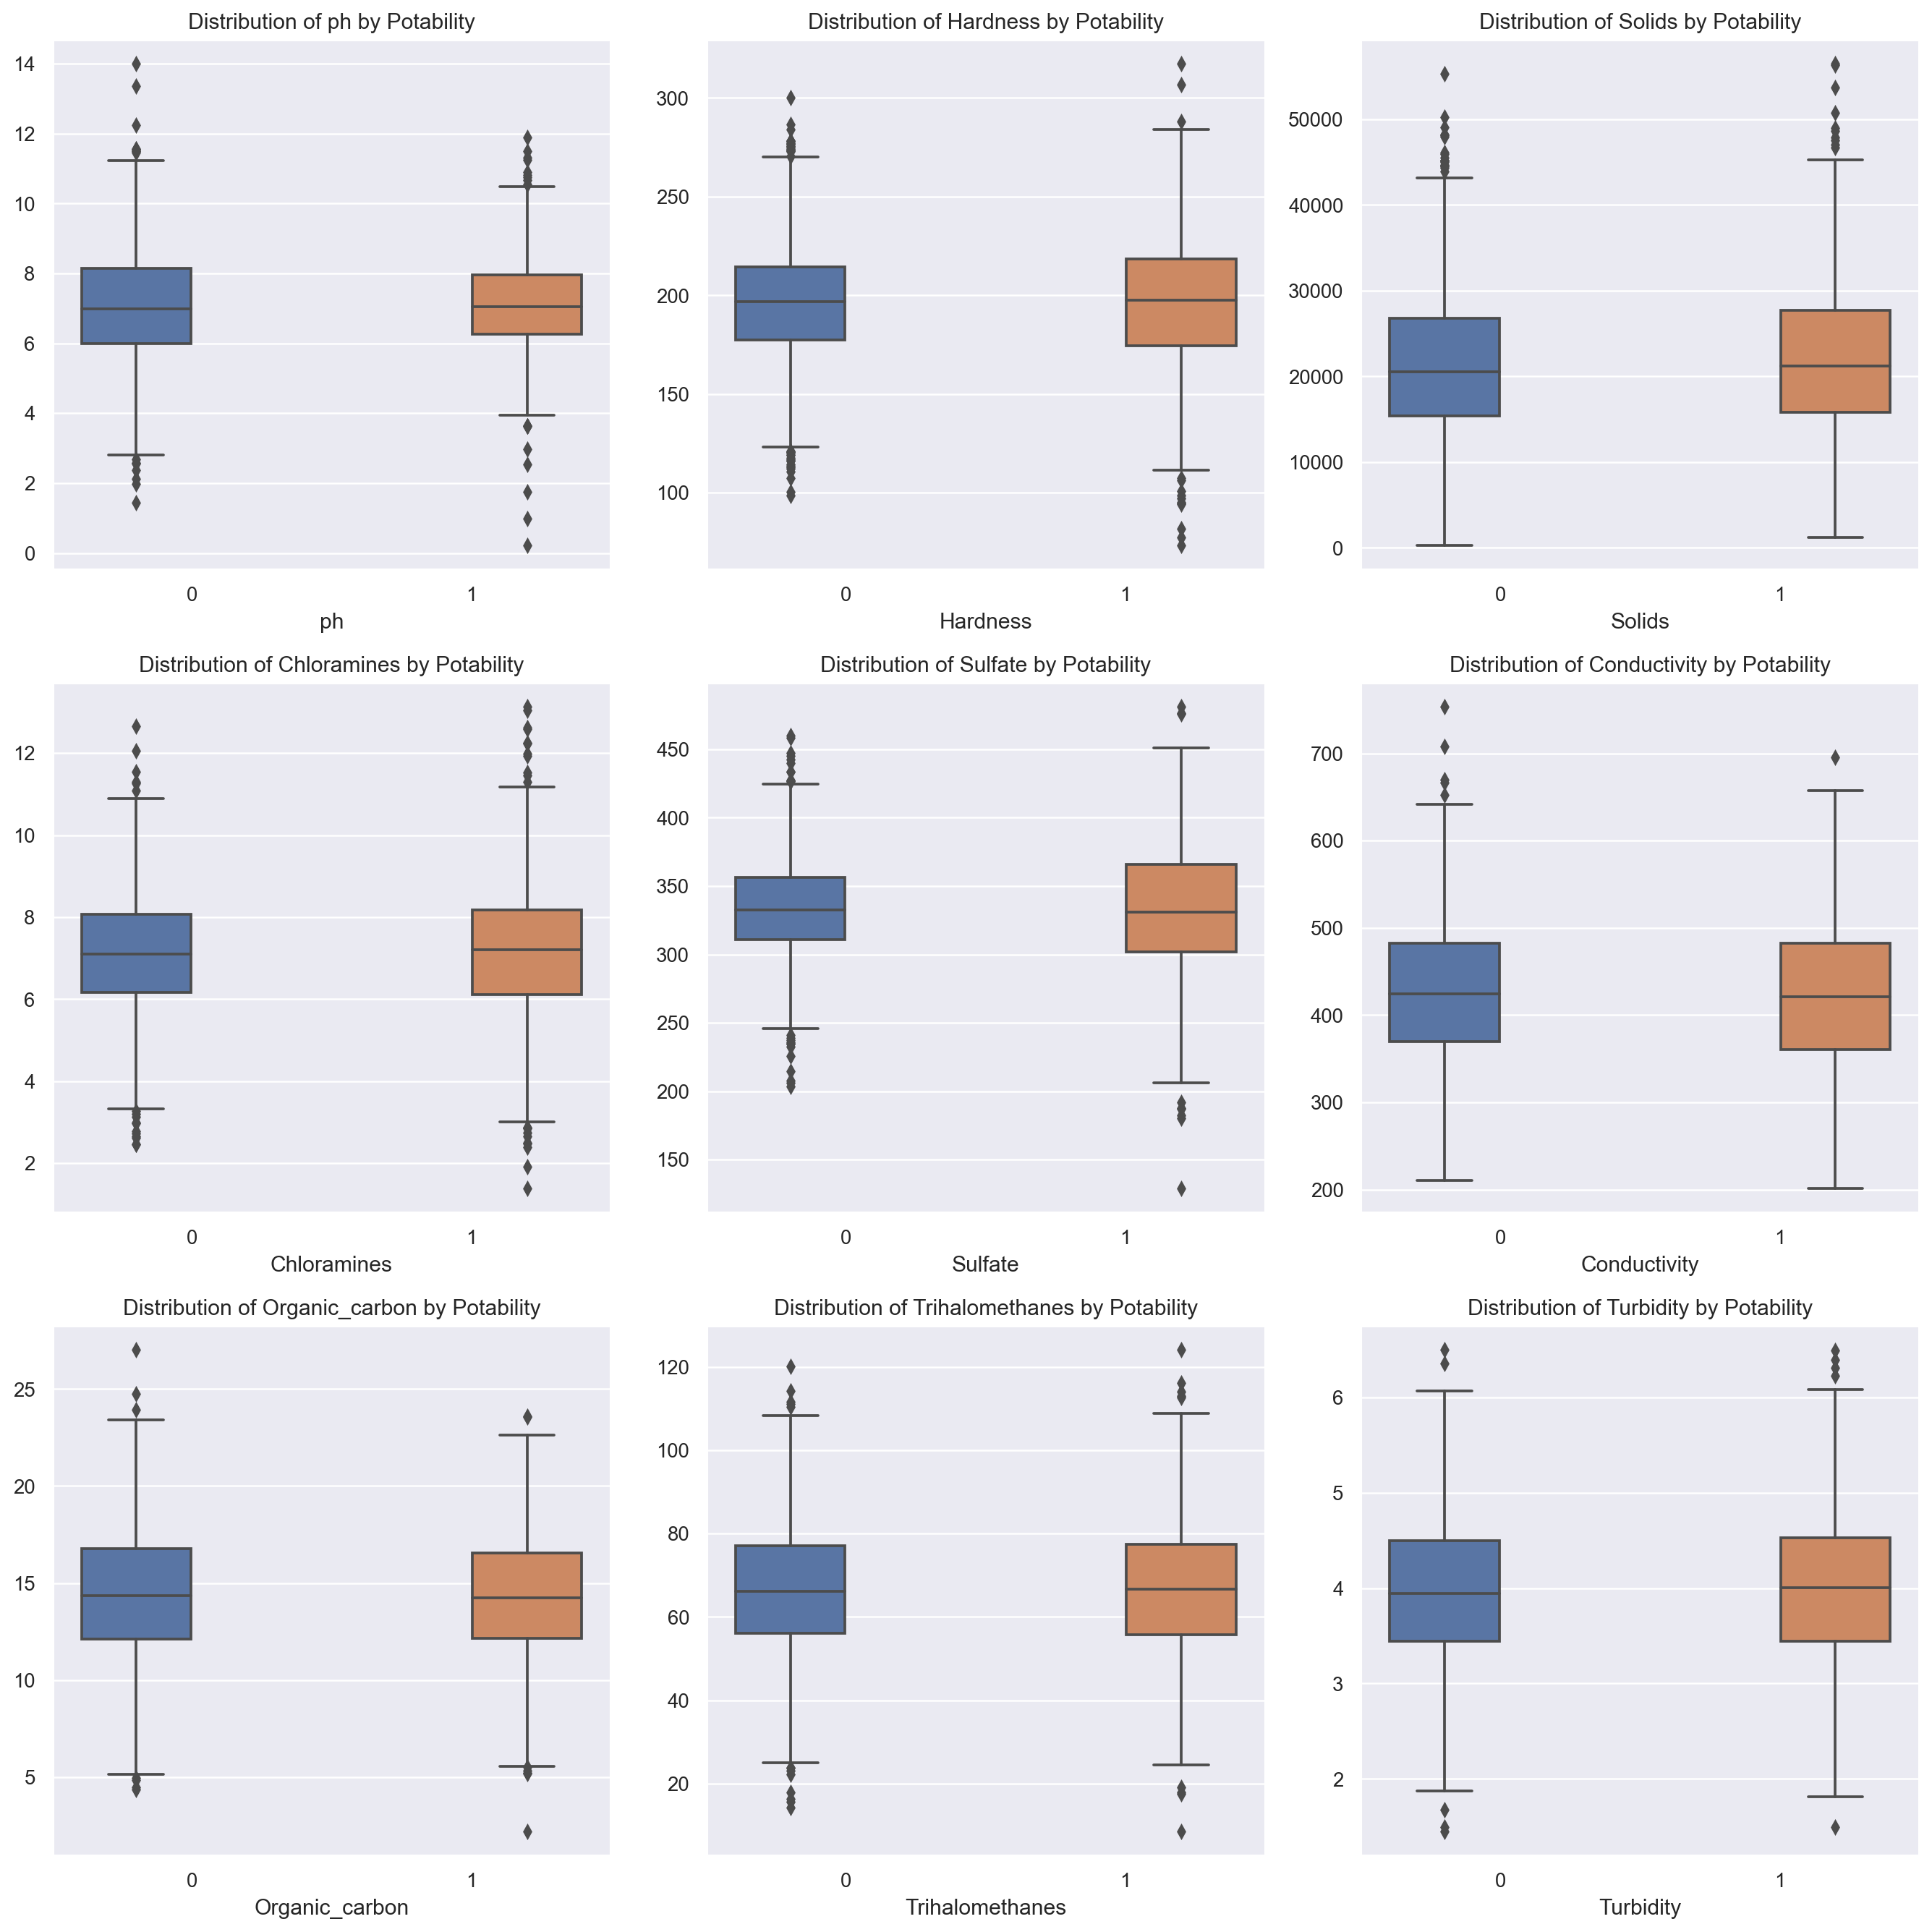

In [17]:
col = df.columns
col = np.array(col[:-1])

fig, axes = plt.subplots(3, 3, figsize=(15, 15), dpi=180)

# I convert 'Potability' to a string
df['Potability'] = df['Potability'].astype(str)

for i, ax in enumerate(axes.ravel()):
    if i < len(df.columns) - 1:
        col_name = df.columns[i]
        sns.boxplot(data=df, y=col_name, x='Potability', hue='Potability', ax=ax)
        ax.set_title(f'Distribution of {col_name} by Potability')
        ax.set_xlabel(col_name)
        ax.set_ylabel('')
        ax.legend_.remove()

plt.tight_layout()
plt.show()

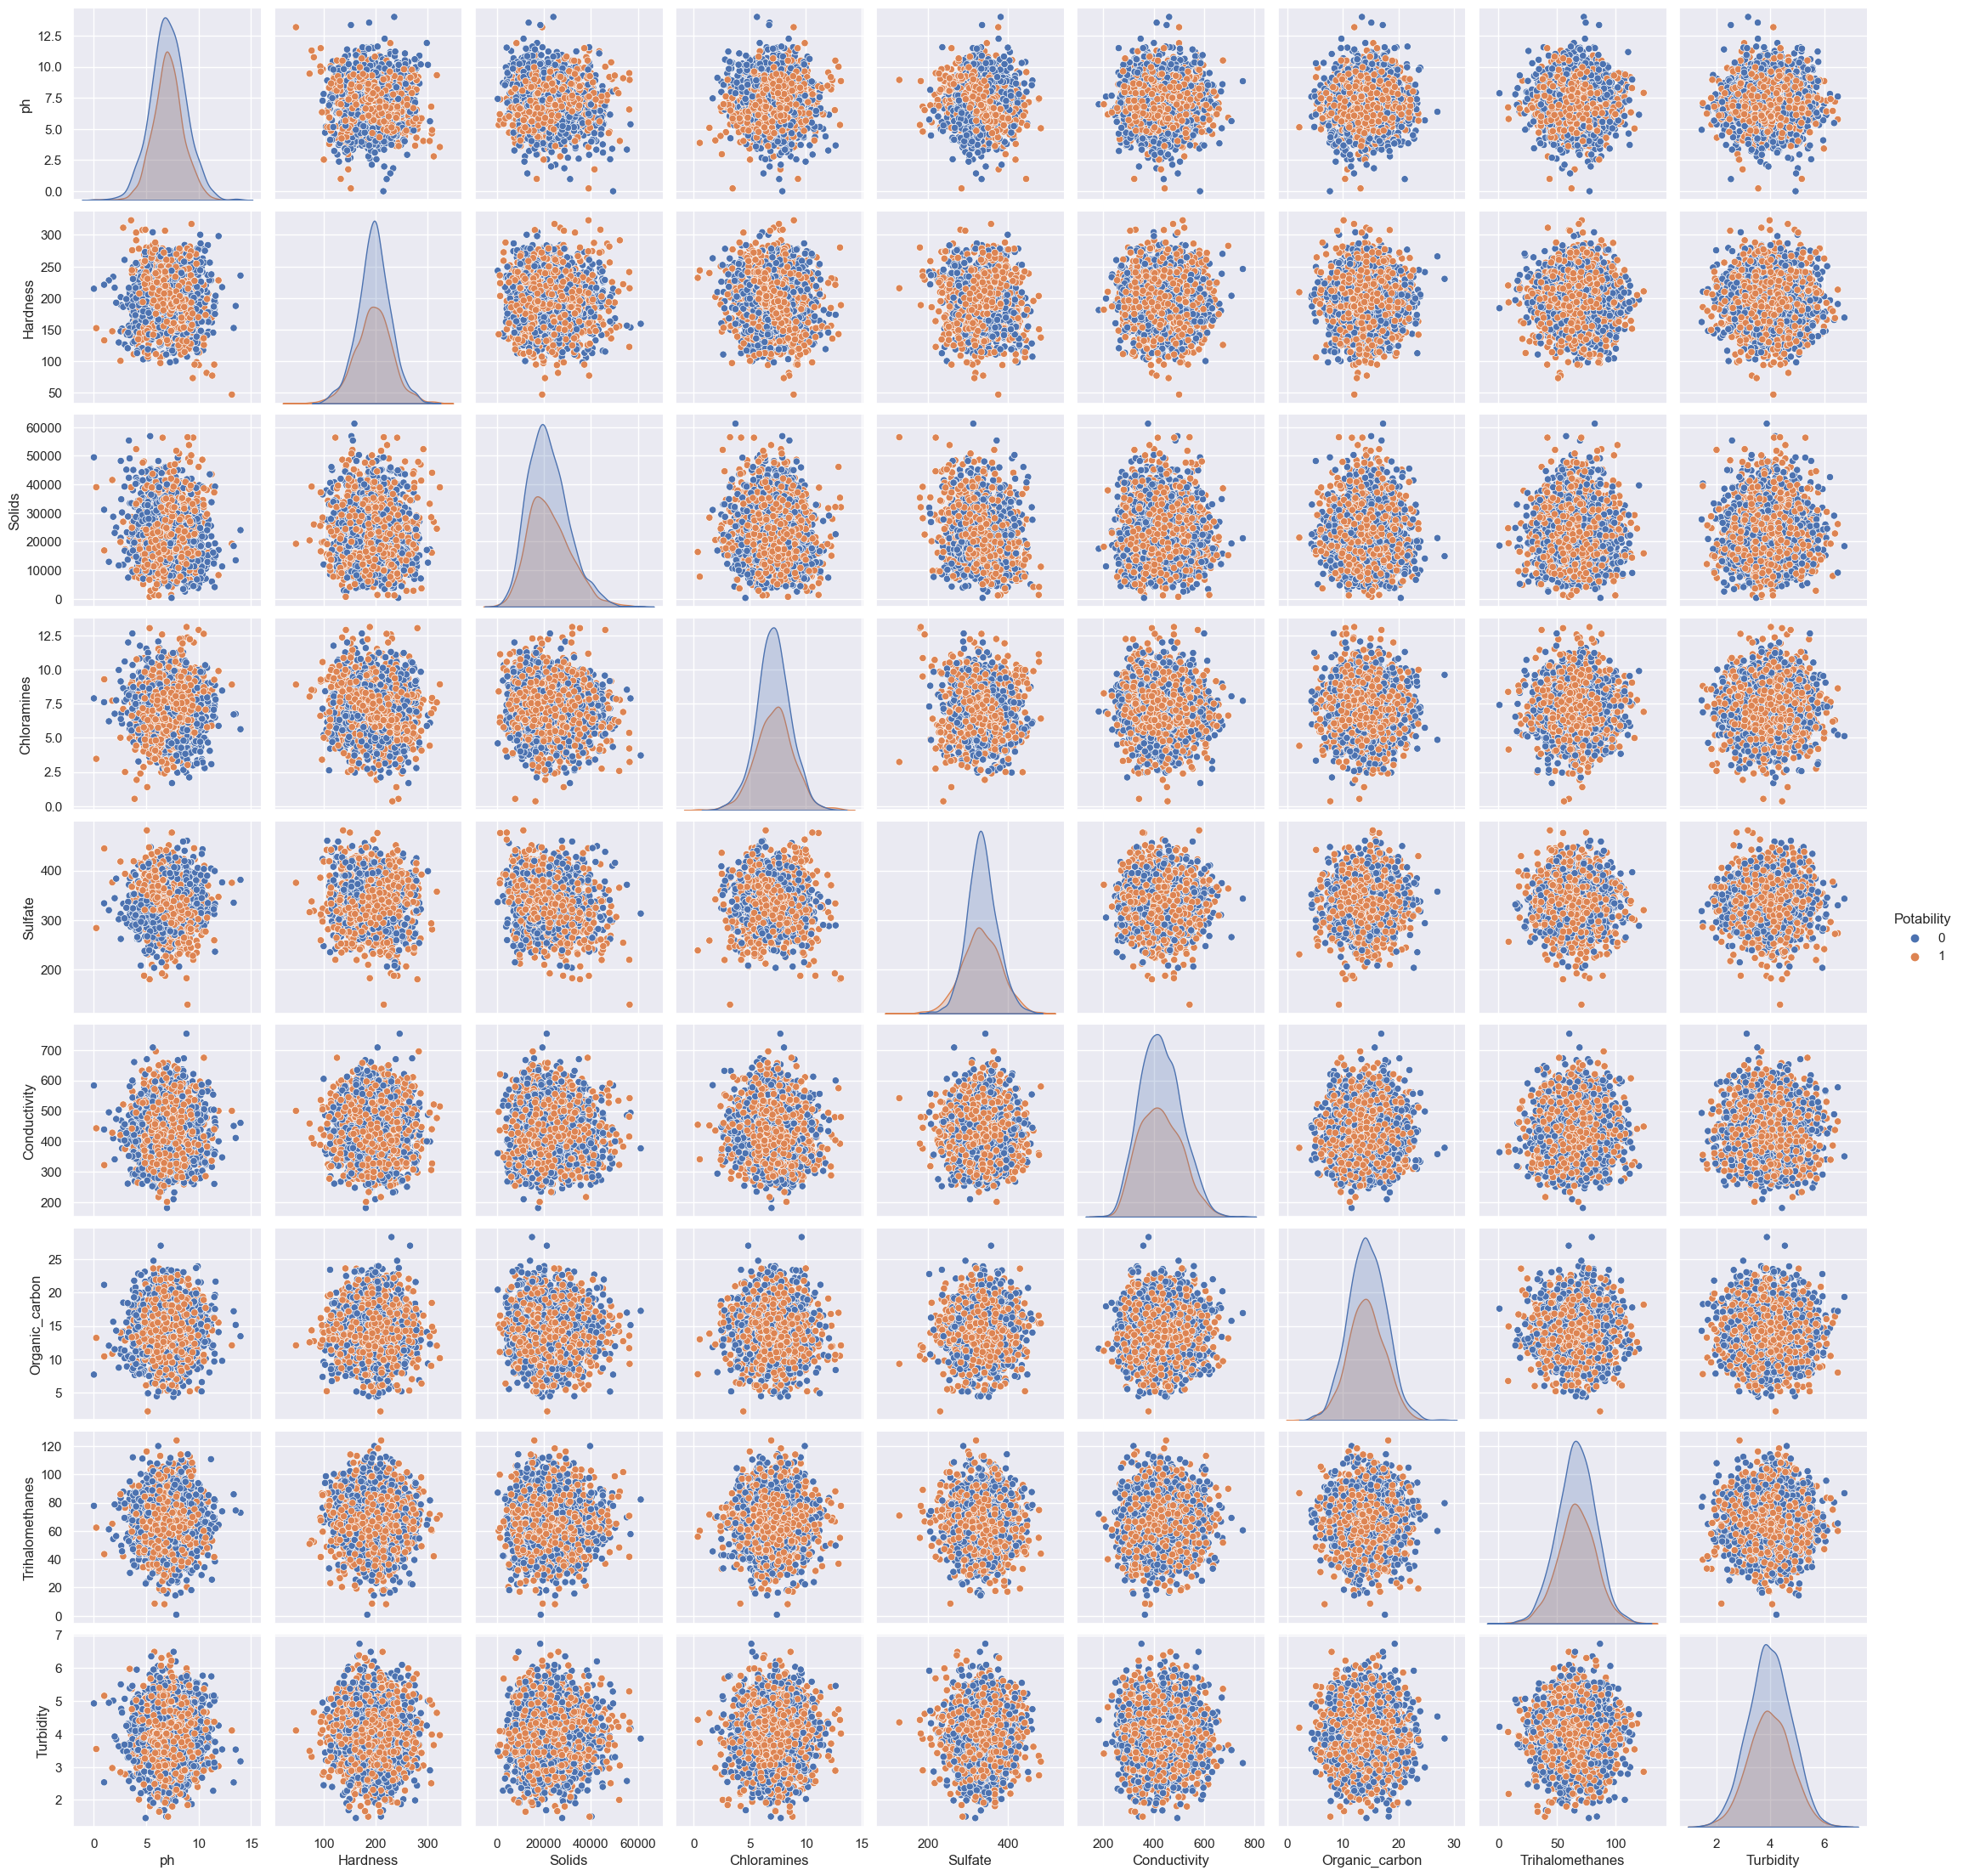

In [15]:
sns.pairplot(data=df, hue='Potability');

## Data Preprocessing

In [19]:
X = df.drop('Potability', axis=1)
y = df['Potability']

In [20]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X,y)

In [21]:
print(y_test.value_counts())
print()
print(y_val.value_counts())
print()
print(y_train.value_counts())

Potability
0    180
1    122
Name: count, dtype: int64

Potability
0    180
1    122
Name: count, dtype: int64

Potability
0    840
1    567
Name: count, dtype: int64


In [22]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_eval_scaled = scaler.transform(X_val)

## Model Evalueation

In [27]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)
def classification_models():
    models = []
    models.append(('RandomForest', RandomForestClassifier(random_state=10)))
    models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state=10)))
    models.append(('XGBClassifier', XGBClassifier(random_state=10)))
    models.append(('AdaBoost', AdaBoostClassifier(random_state=10)))
    models.append(('svc', SVC(random_state=10, kernel='rbf')))
    models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state=10)))
    models.append(('GaussianNB', GaussianNB()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('LogisticRegression', LogisticRegression(random_state=10)))
    models.append(('GaussianProcessClassifier', GaussianProcessClassifier()))
    
    return models

models = classification_models()

In [28]:
def model_fit_evaluate(models, X_train, y_train, X_test, y_test):
    # fit
    for model in models:
        print(f"{model[0]}\n")
        model[1].fit(X_train, y_train)
        y_pred = model[1].predict(X_test)
        
        # Evaluation
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred)
    
        # show
        print(f"""
Confusion Matrix:\n{cm}\n
                classification report:\n{cr}\n
{"="*60}
        """)

In [29]:
model_fit_evaluate(models, X_train_scaled, y_train, X_test_scaled, y_test)

RandomForest


Confusion Matrix:
[[159  21]
 [ 69  53]]

                classification report:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78       180
           1       0.72      0.43      0.54       122

    accuracy                           0.70       302
   macro avg       0.71      0.66      0.66       302
weighted avg       0.70      0.70      0.68       302


        
GradientBoostingClassifier


Confusion Matrix:
[[151  29]
 [ 88  34]]

                classification report:
              precision    recall  f1-score   support

           0       0.63      0.84      0.72       180
           1       0.54      0.28      0.37       122

    accuracy                           0.61       302
   macro avg       0.59      0.56      0.54       302
weighted avg       0.59      0.61      0.58       302


        
XGBClassifier


Confusion Matrix:
[[133  47]
 [ 65  57]]

                classification report:
              precision

## Hyperparameter Tuning

In [30]:
# definizione modelli
model1 = SVC()
model2 = XGBClassifier()
model3 = RandomForestClassifier()

# Parameter for SVC
C = np.linspace(1, 1.4, 30)
param_svc = {
    'C':C,
    'gamma':['scale', 'auto']
}

# Parameter for XGBoost
param_xgb = {
    "n_estimators": [10, 50, 100, 300, 600, 900],
    "max_depth": [2,3,4,5,6,7,8],
    "max_leaves": [0, 1, 2, 3, 4],
    "learning_rate": [.09,.1,.2,.3,.4],
    "subsample": [0, .1,.2,.4,.6,.8]
}

# Parameter for Random Forest
param_rf = {
    "n_estimators": [10, 50, 100, 300, 500, 700, 900],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2,3,4],
    "min_samples_leaf": [1,2,3,4]
}

# I initialize the grids
grid1 = RandomizedSearchCV(estimator=model1, param_distributions=param_svc, n_jobs=-1)
grid2 = RandomizedSearchCV(estimator=model2, param_distributions=param_xgb, n_jobs=-1)
grid3 = RandomizedSearchCV(estimator=model3, param_distributions=param_rf, n_jobs=-1)

In [31]:
grid1.fit(X_train_scaled, y_train)
grid2.fit(X_train_scaled, y_train)
grid3.fit(X_train_scaled, y_train)

best_param1 = grid1.best_params_
best_param2 = grid2.best_params_
best_param3 = grid3.best_params_

In [32]:
print(best_param1)
print("")
print(best_param2)
print("")
print(best_param3)

{'gamma': 'scale', 'C': 1.3448275862068964}

{'subsample': 0.1, 'n_estimators': 900, 'max_leaves': 3, 'max_depth': 7, 'learning_rate': 0.1}

{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'entropy'}


In [38]:
y_pred1 = grid1.predict(X_eval_scaled)
y_pred2 = grid2.predict(X_eval_scaled)
y_pred3 = grid3.predict(X_eval_scaled)

In [40]:
y_val = y_val.astype(int)
print(f"Classification Report Per SVC:\n {classification_report(y_val, y_pred1)}\n")
print(f"Classification Report Per XGB:\n {classification_report(y_val, y_pred2)}\n")
print(f"Classification Report Per  RF:\n {classification_report(y_val, y_pred3)}\n")

Classification Report Per SVC:
               precision    recall  f1-score   support

           0       0.66      0.91      0.77       180
           1       0.70      0.31      0.43       122

    accuracy                           0.67       302
   macro avg       0.68      0.61      0.60       302
weighted avg       0.68      0.67      0.63       302


Classification Report Per XGB:
               precision    recall  f1-score   support

           0       0.67      0.70      0.68       180
           1       0.52      0.48      0.50       122

    accuracy                           0.61       302
   macro avg       0.59      0.59      0.59       302
weighted avg       0.61      0.61      0.61       302


Classification Report Per  RF:
               precision    recall  f1-score   support

           0       0.69      0.89      0.77       180
           1       0.71      0.40      0.51       122

    accuracy                           0.69       302
   macro avg       0.70      0

In [41]:
model1 = SVC(**best_param1, probability=True)
model2 = XGBClassifier(**best_param2)
model3 = RandomForestClassifier(**best_param3)

In [42]:
ensemble = VotingClassifier(
    estimators=[('SVC', model1), ('XGB', model2), ("RF", model3)], 
    voting='soft'
)

ensemble.fit(X_train_scaled, y_train)

pred_ens = ensemble.predict(X_eval_scaled)

In [43]:
print(classification_report(y_val, pred_ens))

              precision    recall  f1-score   support

           0       0.67      0.81      0.73       180
           1       0.58      0.40      0.48       122

    accuracy                           0.64       302
   macro avg       0.62      0.60      0.60       302
weighted avg       0.63      0.64      0.63       302



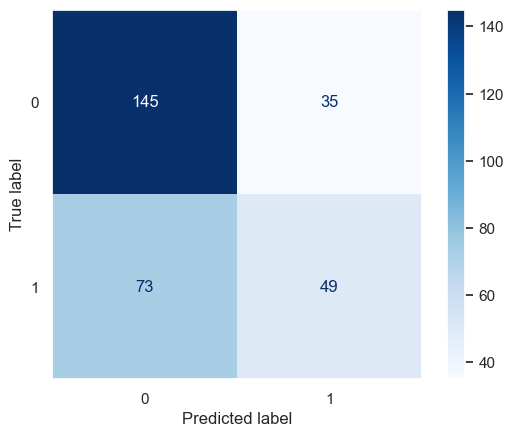

In [44]:
cm = confusion_matrix(y_val, pred_ens)
disp = ConfusionMatrixDisplay(cm, display_labels=None)
disp.plot(cmap=plt.cm.Blues, values_format='d')
disp.ax_.grid(False);

## Conclusions:

1) These models cannot predict water potability with an acceptable level of confidence. To enable a more detailed analysis, a larger dataset is required, and additional features should be incorporated to transition to more complex models.

2) As we can observe from the distributions, the two sets of data are challenging to separate, given their closely resembling distributions. It is likely that with the assistance of a neural network and a larger dataset, acceptable results could be achieved.